### This notebook provides simple EDA for Age & Gender classification task
I use [OUI-Adience Face collection* dataset](https://talhassner.github.io/home/projects/Adience/Adience-data.html), 

it contains over 25k photos of Face images, cropped and aligned and 8 different age groups (0-2, 4-6, 8-13, 15-20, 25-32, 38-43, 48-53, 60-)

In [ ]:
# install needed packages
!pip install pandas numpy opencv-python matplotlib

In [1]:
USER = ""
PASSWORD = ""
# download and extract data, obtain user and password from site above
# !wget --user $USER --password $PASSWORD http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz
# !wget --user $USER --password $PASSWORD http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_0_data.txt
# !wget --user $USER --password $PASSWORD http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_1_data.txt
# !wget --user $USER --password $PASSWORD http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_2_data.txt
# !wget --user $USER --password $PASSWORD http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_3_data.txt
# !wget --user $USER --password $PASSWORD http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_4_data.txt
# !tar xf aligned.tar.gz

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# folder with images
ROOT = Path("aligned")

In [4]:
df = pd.concat([
    pd.read_csv(f"fold_{i}_data.txt", sep="\t")
    for i in range(5)
])

In [5]:
df.count()

user_id               18781
original_image        18781
face_id               18781
age                   18781
gender                18071
x                     18780
y                     18780
dx                    18780
dy                    18780
tilt_ang              18780
fiducial_yaw_angle    18780
fiducial_score        18780
dtype: int64

We have some number of NaN gender values, let's drop them

In [6]:
df.dropna(inplace=True)
df.head(5)

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0.0,414.0,1086.0,1383.0,-115.0,30.0,17.0
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301.0,105.0,640.0,641.0,0.0,0.0,94.0
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395.0,876.0,771.0,771.0,175.0,-30.0,74.0
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752.0,1255.0,484.0,485.0,180.0,0.0,47.0
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175.0,80.0,769.0,768.0,-75.0,0.0,34.0


In [7]:
df.gender.value_counts()

f    9164
m    7986
u     921
Name: gender, dtype: int64

921 unknown gender labels, let's look at them

In [8]:
df_subset = df[df.gender == 'u']
gender_unknown_paths = df_subset.apply(
    axis=1, 
    func=lambda item: f"{item.user_id}/landmark_aligned_face.{item.face_id}.{item.original_image}"
).values

In [9]:
def image_grid(images):
    fig, ax = plt.subplots(1, len(images), figsize=(10, 10))
    for i, im in enumerate(images):
        ax[i].imshow(im)

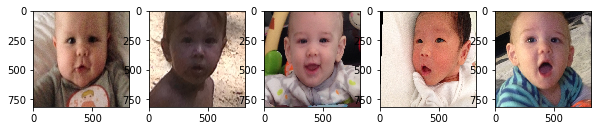

In [12]:
# show 5 random images
images = [
    cv2.imread(str(ROOT.joinpath(gender_unknown_paths[idx])))[..., ::-1]
    for idx in np.random.randint(len(gender_unknown_paths), size=5)
]
image_grid(images)

So it's mostly images of newborn, that's why we don't know their gender

In [13]:
# age distribution
df.age.value_counts()

(25, 32)     4764
(0, 2)       2310
(38, 43)     2237
(4, 6)       2135
(8, 12)      2088
(15, 20)     1614
(60, 100)     860
(48, 53)      807
35            287
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             74
36             56
(38, 42)       46
None           40
57             24
3              18
29             11
(38, 48)        6
58              5
2               3
42              1
(8, 23)         1
46              1
Name: age, dtype: int64

I see that some age intervals are separated (age 3, 13, 22, 23, 34, 35, 36, 45, 46, 55, 57, 58)

I will put those values in new categories by hand and at the same time encode into categories

In [14]:
# new categories are 0-2, 3-6, 8-13, 15-20, 22-32, 34-43, 45-53, 55-100
age_label2id = {
    '(0, 2)': 0,
    '3': 1,
    '(4, 6)': 1,
    '(8, 12)': 2,
    '13': 2,
    '(15, 20)': 3,
    '22': 4,
    '23': 4,
    '(25, 32)': 4,
    '34': 5,
    '35': 5,
    '36': 5,
    '(38, 43)': 5,
    '45': 6,
    '46': 6,
    '(48, 53)': 6,
    '55': 7,
    '57': 7,
    '58': 7,
    '(60, 100)': 7
}
gender_label2id = {'f': 0, 'm': 1, 'u': 2}
df['age_id'] = df.age.map(age_label2id).astype(float)
df['gender_id'] = df.gender.map(gender_label2id).astype(float)

In [15]:
# there are nearly 200 items that are non-mapped, drop them
df.dropna(inplace=True)

In [16]:
paths = df.apply(
    axis=1, 
    func=lambda item: f"{item.user_id}/landmark_aligned_face.{item.face_id}.{item.original_image}"
).values.tolist()

We have our final labels, save only paths and gender/age ids in json format

In [17]:
json.dump(
    {paths[i]: {"age_id": df.age_id.values[i], "gender_id": df.gender_id.values[i]} for i in range(len(paths))},
    ROOT.joinpath("labels.json").open("w")
)